## after a PC restart, intake-esm is now working ¯|_(ツ)_/¯

In [1]:
import intake
import numpy as np

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(experiment_id=['historical'], variable_id='fgco2',
                 grid_label='gn', table_id='Omon')

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import fsspec

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6

## load CMIP6

In [4]:
dset_dict = {}
for name, group in cat.df.groupby('source_id'):
    dsets = [xr.open_zarr(fsspec.get_mapper(zstore), consolidated=True)
             for zstore in group.zstore.values]
    try:
        dsets_aligned = xr.align(*dsets, join='exact')
        dset_dict[name] = xr.concat(dsets, dim='member')
        print(f'concatted {name}')
    except Exception as e:
        print(f'failed to concat {name}')
        print(e)

concatted ACCESS-ESM1-5
concatted BCC-CSM2-MR
concatted BCC-ESM1
concatted CESM2
concatted CESM2-FV2
concatted CESM2-WACCM
concatted CESM2-WACCM-FV2
concatted CNRM-ESM2-1
concatted CanESM5
concatted CanESM5-CanOE
concatted GISS-E2-1-G
concatted GISS-E2-1-G-CC
concatted IPSL-CM6A-LR
concatted MIROC-ES2L
concatted MPI-ESM-1-2-HAM
concatted MPI-ESM1-2-HR
concatted MPI-ESM1-2-LR
concatted MRI-ESM2-0
concatted NorCPM1
concatted NorESM2-LM
concatted NorESM2-MM
failed to concat UKESM1-0-LL
indexes along dimension 'time' are not equal


,Array,Chunk
Bytes,10.71 GB,58.98 MB
Shape,"(11, 1980, 384, 320)","(1, 120, 384, 320)"
Count,1044 Tasks,297 Chunks
Type,float32,numpy.ndarray


C:\Users\sukic\Anaconda3\envs\geosci\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


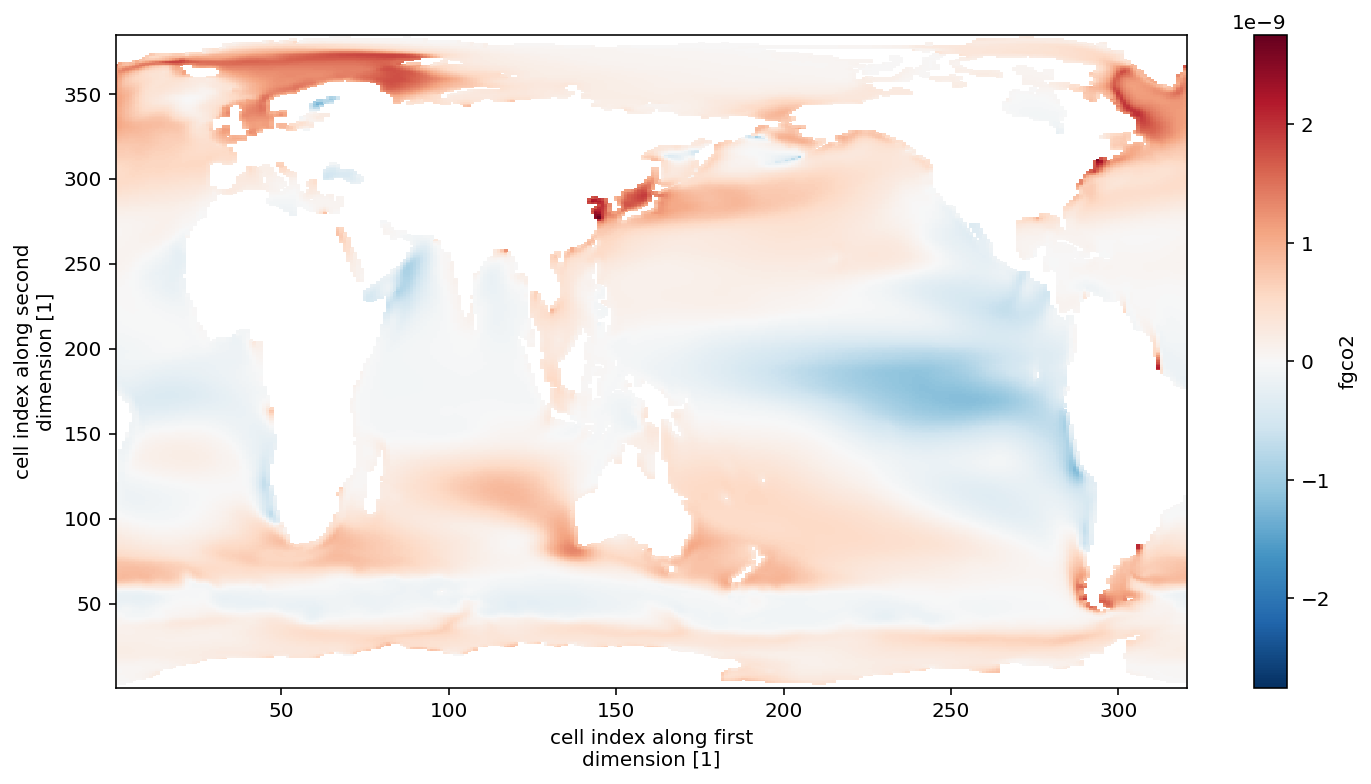

In [5]:
# look at one model
ds = dset_dict['CESM2']
display(ds)
# calculate ensemble mean annual flux in year 2000
fgco2 = ds.fgco2.sel(time='2000', method='nearest').mean(dim=['time', 'member']).load()
fgco2.plot()

## Import .nc biome files

In [6]:
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
from netCDF4 import Dataset

In [7]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print('\t\ttype:', repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim )
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [8]:
# View attributes in nc file
nc_f = '../biomes/Time_Varying_Biomes.nc'
nc_fid = Dataset(nc_f, 'r')
nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)

NetCDF Global Attributes:
	Title: 'Global Biomes'
	Description: 'Global Mean, Core, and Time-varying Biomes for years 1998-2010'
	Authors: 'AR Fay and GA McKinley University of Wisconsin'
	Date: 'June 2014'
	Notes: 'Biomes as described in Fay & McKinley, (2014) Global open ocean biomes: mean and temporal variability, Earth System Science Data. '
NetCDF dimension information:
	Name: lat
		size: 180
		type: dtype('float64')
		units: 'degrees latitude'
	Name: lon
		size: 360
		type: dtype('float64')
		units: 'degrees longitude'
	Name: year
		size: 13
		type: dtype('float64')
		units: 'years'
NetCDF variable information:
	Name: MeanBiomes
		dimensions: ('lon', 'lat')
		size: 64800
		type: dtype('float64')
		Fill_value: 'NaN'
	Name: CoreBiomes
		dimensions: ('lon', 'lat')
		size: 64800
		type: dtype('float64')
		Fill_value: 'NaN'
	Name: TimeVaryingBiomes
		dimensions: ('lon', 'lat', 'year')
		size: 842400
		type: dtype('float64')
		Fill_value: 'NaN'


## Plot biomes 5 and 6 (WEP and EEP)

In [9]:
def plot_biomes(biome_no, plot=True):
    '''
    This function plots biomes from Fay and McKinley's global ocean biomes
    
    Parameters
    ----------
    biome_no : int
    plot : bool
    
    Returns
    -------
    g : plot
    biomes : array of all biomes
    
    '''
    # Your filename
    nc_f = '../biomes/Time_Varying_Biomes.nc'
    nc_fid = Dataset(nc_f, 'r')
    nc_attrs, nc_dims, nc_vars = ncdump(nc_fid,verb=False)

    
    # Extract data from NetCDF file
    lats = nc_fid.variables['lat'][:]  # extract/copy the data
    lons = nc_fid.variables['lon'][:]
    mean_biomes = nc_fid.variables['MeanBiomes'][:]

    m = Basemap(projection='cyl', resolution='c', lon_0=180)
    m.drawcoastlines()
    m.fillcontinents()

    # Make the plot continuous
    biomes_cyclic, lons_cyclic = addcyclic(mean_biomes.T, lons)

    # Shift the grid so lons go from 0 to 360 instead of -180 to 180
    biomes, lons_cyclic = shiftgrid(0, biomes_cyclic, lons_cyclic, start=True)

    # Create 2D lat/lon arrays for Basemap
    lon2d, lat2d = np.meshgrid(lons_cyclic, lats)

    # Transforms lat/lon into plotting coordinates for projection
    x, y = m(lon2d, lat2d)

    # plot biomes
    g = m.contour(x,y,biomes==biome_no,colors='xkcd:ocean blue',linewidths=.5)
    
    if plot == False:
        plt.close()
    
    return g, biomes

C:\Users\sukic\Anaconda3\envs\geosci\lib\site-packages\numpy\ma\core.py:3188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


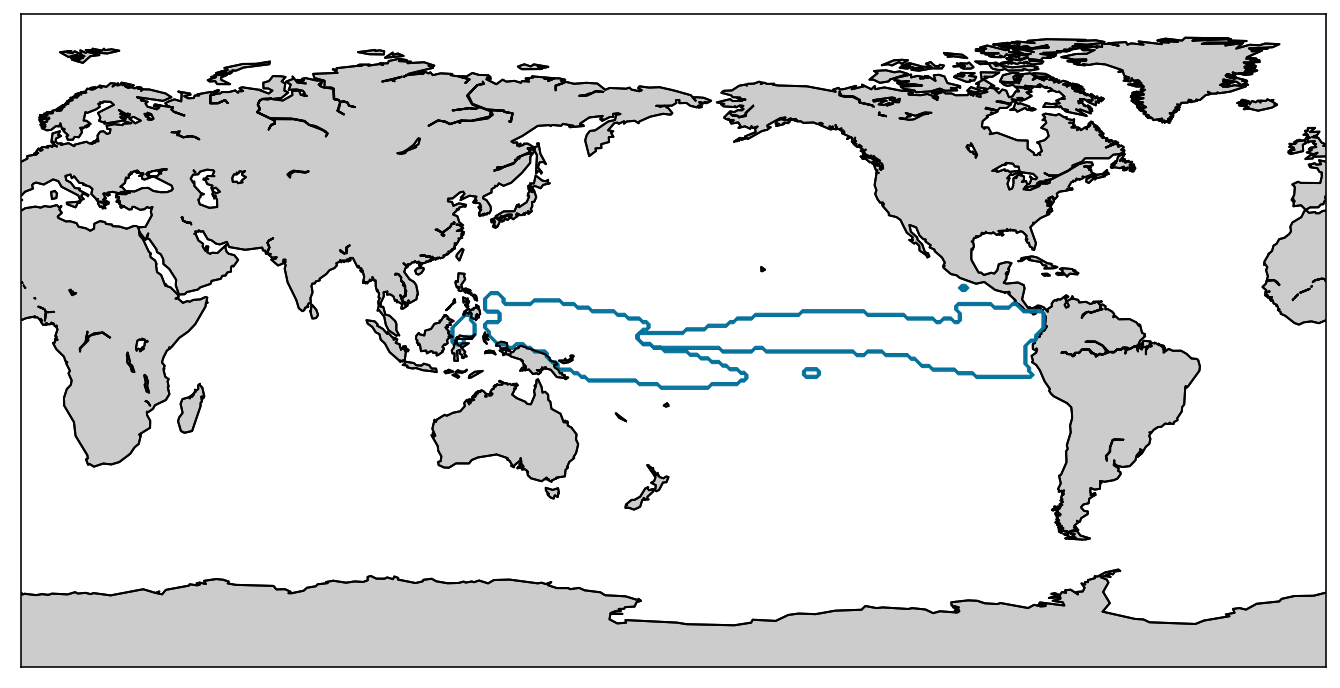

In [10]:
wep, biomes = plot_biomes(5)
eep, biomes = plot_biomes(6)

In [11]:
def make_biome_array(biome_no):
    
    # obtain biome array, without plotting
    wep, biomes = plot_biomes(biome_no, False)
    
    # find indices of specific biome
    x, y = np.where(biomes==biome_no)

    # make array for a specific biome
    biome = np.zeros((180,361))
    for i,v in zip(x,y):
        biome[i,v] = 1.
        
    return biome

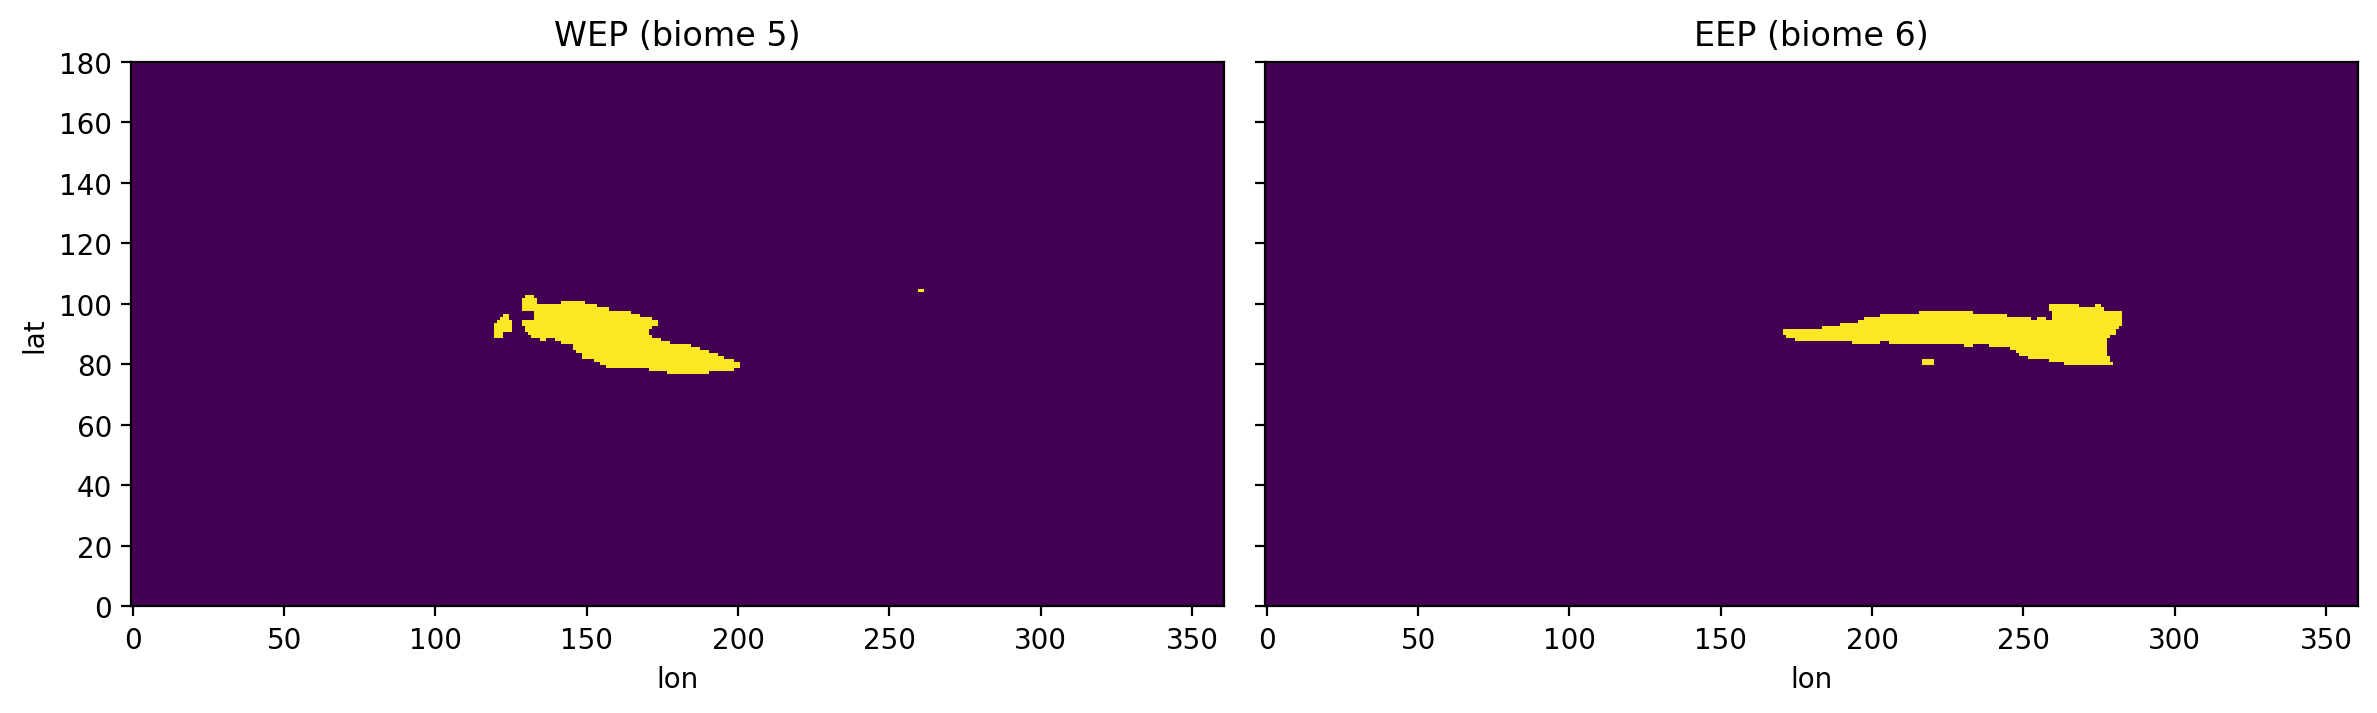

In [12]:
biome5 = make_biome_array(5)
biome6 = make_biome_array(6)

fig, axes = plt.subplots(nrows=1,ncols=2,dpi=100,sharey=True)

axes[0].imshow(biome5)
axes[1].imshow(biome6)


axes[0].set_title('WEP (biome 5)')
axes[1].set_title('EEP (biome 6)')

axes[0].set_ylabel('lat')
axes[0].set_xlabel('lon')
axes[1].set_xlabel('lon')
axes[1].set_ylim([0,180])
plt.tight_layout()

In [75]:
# # save these arrays for future use
# # different models may have different grid sizes, so this will need to be implemented in the future
# np.save('biome_5',biome5)
# np.save('biome_6',biome6)

 ## Apply biome masks onto CMIP6 grid
 >biome shape is (180,361)
 >
 >CMIP6 CESM2 shape is (384,320)

In [32]:
# I doubled 320 to 640 (the longitude scale) so that its grid would be larger than the biome grids
cmip6_shape_5 = np.zeros((384,640))
cmip6_shape_6 = np.zeros((384,640))

In [33]:
# inserted the biome grid into the larger cmip6 grid
cmip6_shape_5[:biome5.shape[0],:biome5.shape[1]] = biome5
cmip6_shape_6[:biome6.shape[0],:biome6.shape[1]] = biome6

In [34]:
g = np.resize(cmip6_shape_5,(384,320))
g2 = np.resize(cmip6_shape_6,(384,320))

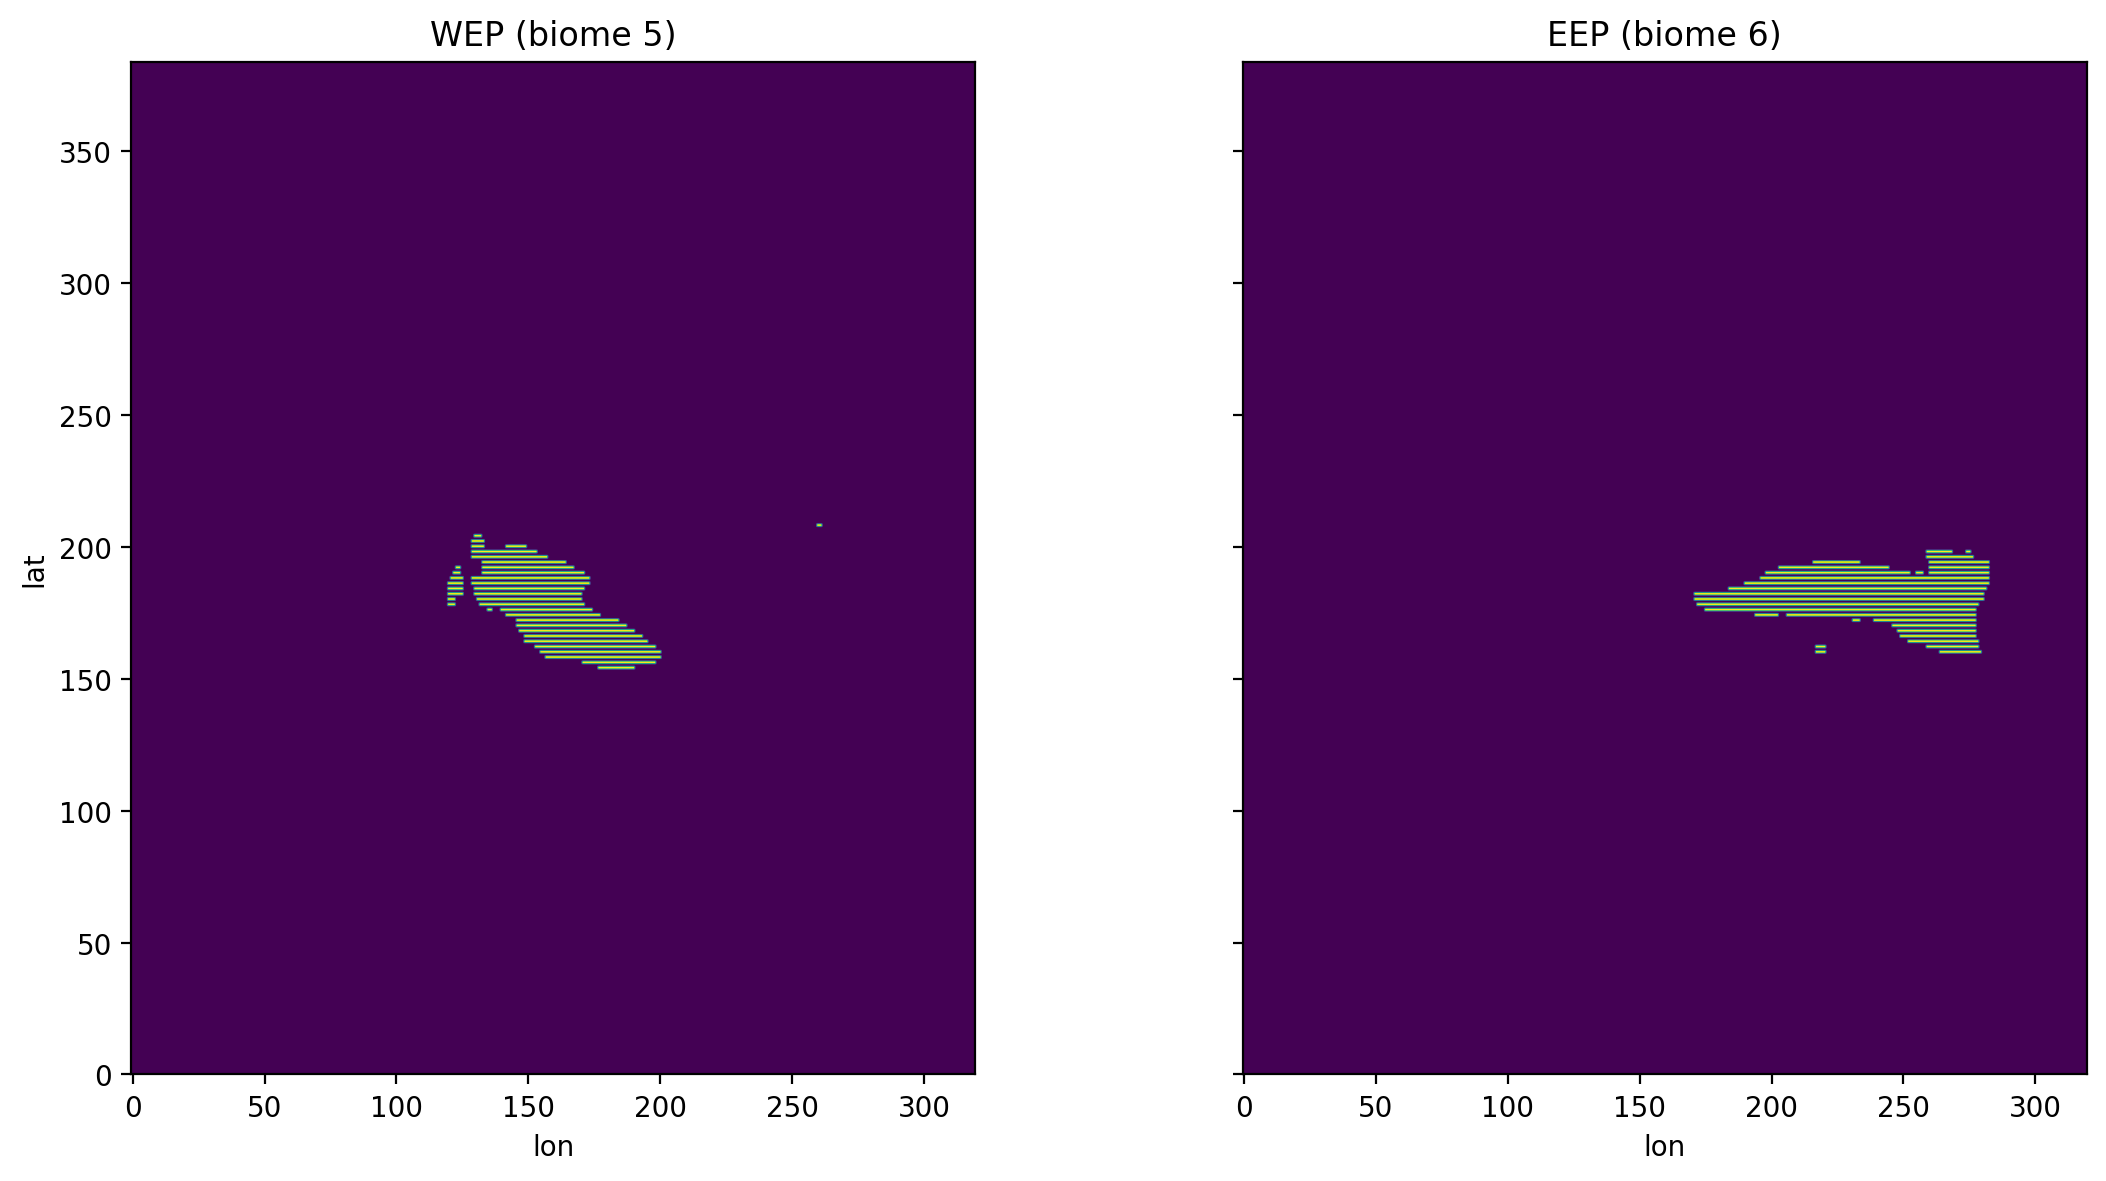

In [35]:
fig, axes = plt.subplots(nrows=1,ncols=2,dpi=100,sharey=True)
axes[0].imshow(g)
axes[1].imshow(g2)

axes[0].set_title('WEP (biome 5)')
axes[1].set_title('EEP (biome 6)')

axes[0].set_ylabel('lat')
axes[0].set_xlabel('lon')
axes[1].set_xlabel('lon')
axes[1].set_ylim([0,384])
plt.tight_layout()

> Resizing using np.resize() semi-worked. The mask is there, but is not properly interpolated

#### Installed opencv, and using cv2.resize() I am able to interpolate a 2D array.

In [13]:
import cv2

In [14]:
img = biome5

# multiple interpolation methods available - what do we have?
area = cv2.resize(img, dsize=(320, 384), interpolation=cv2.INTER_AREA)
nearest = cv2.resize(img, dsize=(320, 384), interpolation=cv2.INTER_NEAREST)
linear = cv2.resize(img, dsize=(320, 384), interpolation=cv2.INTER_LINEAR)
cubic = cv2.resize(img, dsize=(320, 384), interpolation=cv2.INTER_CUBIC)
# Lanczos interpolation over 8x8 pixel neighborhood - seems fancy...
lanczos = cv2.resize(img, dsize=(320, 384), interpolation=cv2.INTER_LANCZOS4)

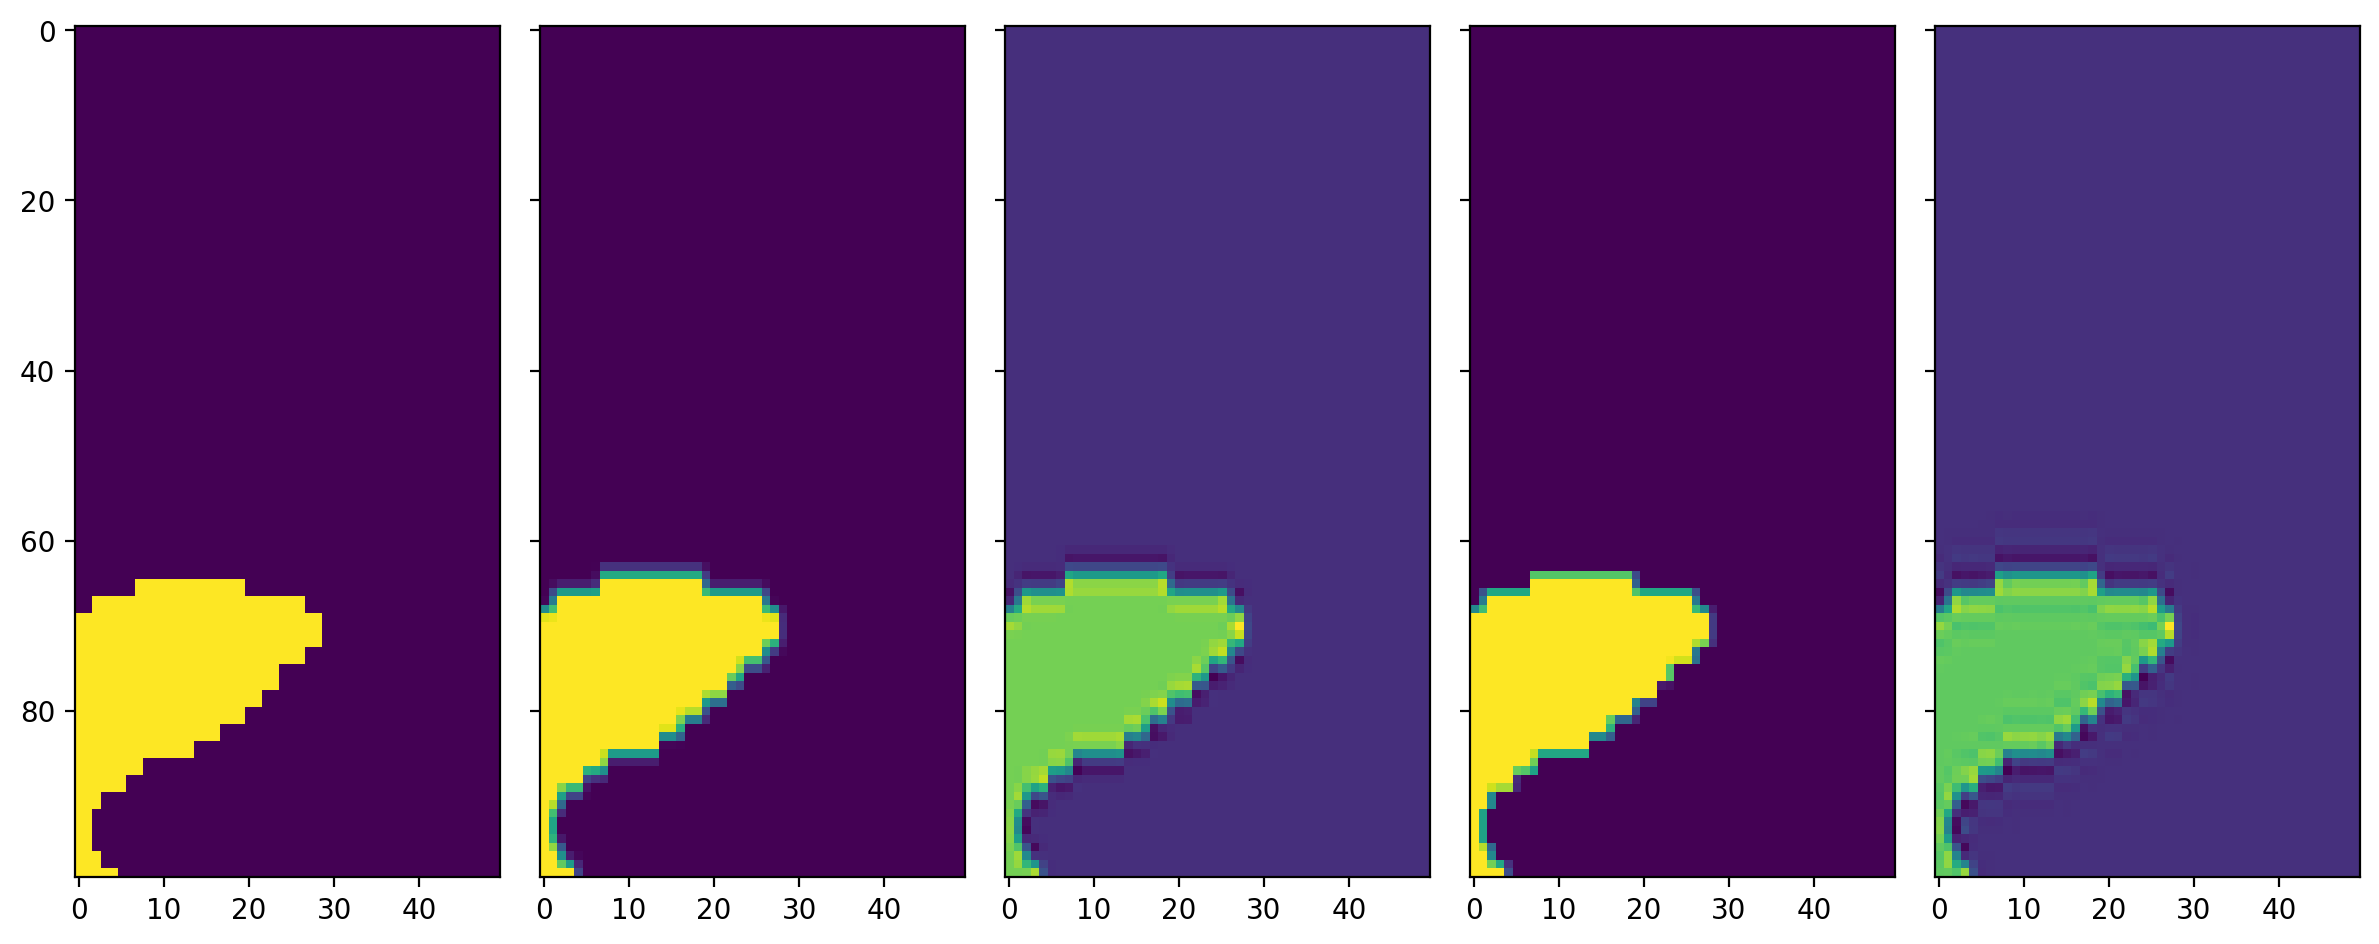

In [15]:
# compare different interpolation methods 
fig, axes = plt.subplots(nrows=1,ncols=5,dpi=100,sharey=True)
axes[0].imshow(nearest[100:200,150:200])
axes[1].imshow(linear[100:200,150:200])
axes[2].imshow(cubic[100:200,150:200])
axes[3].imshow(area[100:200,150:200])
axes[4].imshow(lanczos[100:200,150:200])

plt.tight_layout()

> I pick the **nearest neighbour** interpolation method, because it is the simplest, and seems to be fine for the purposes of a boolean mask array

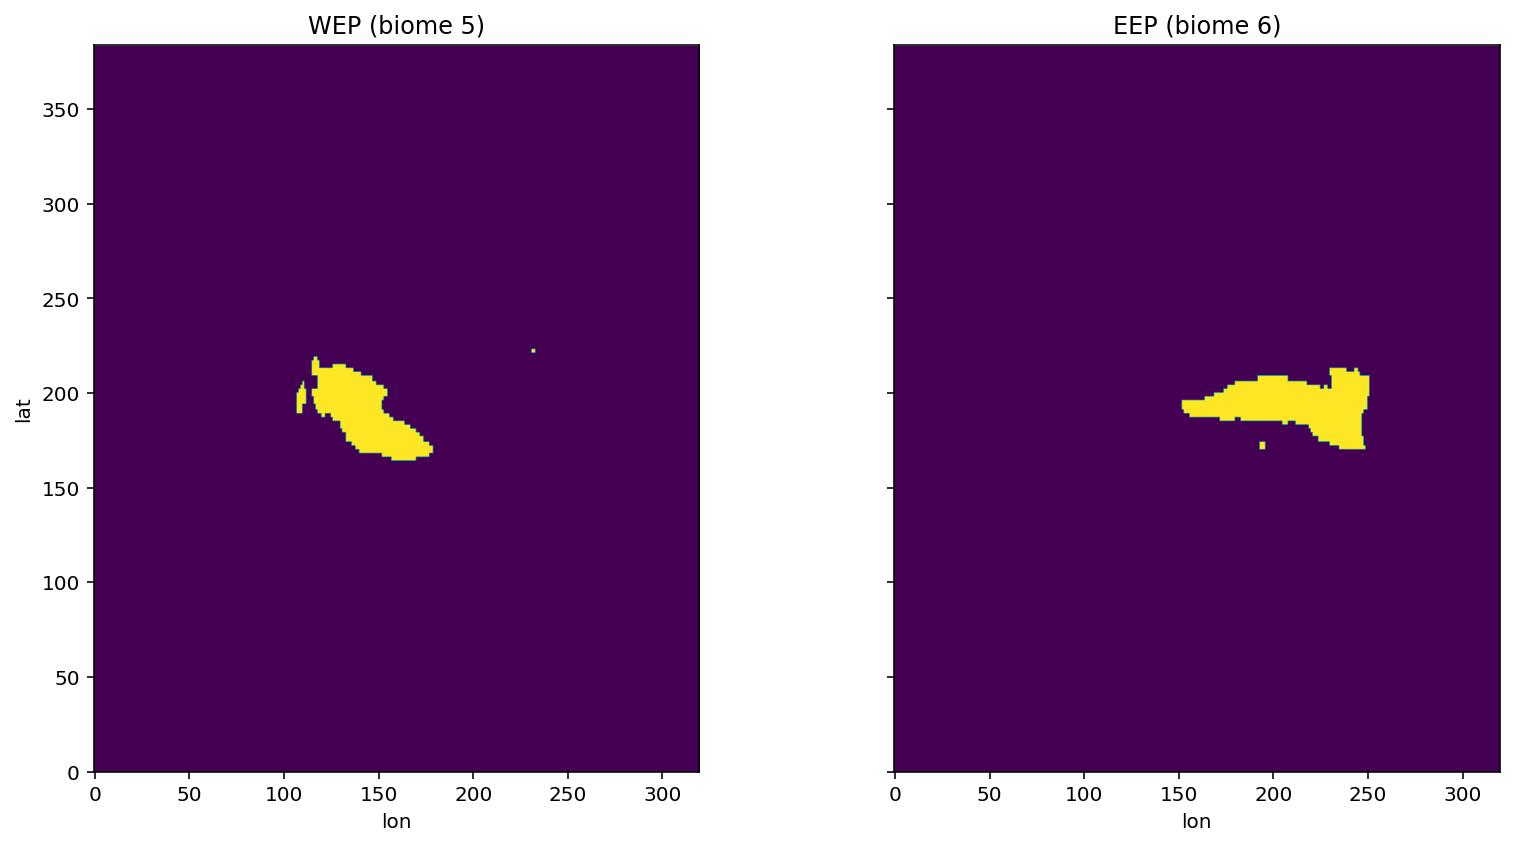

In [16]:
img = biome5
nearest_5 = cv2.resize(img, dsize=(320, 384), interpolation=cv2.INTER_NEAREST)

img2 = biome6
nearest_6 = cv2.resize(img2, dsize=(320, 384), interpolation=cv2.INTER_NEAREST)

fig, axes = plt.subplots(nrows=1,ncols=2,sharey=True)
axes[0].imshow(nearest_5)
axes[1].imshow(nearest_6)

axes[0].set_title('WEP (biome 5)')
axes[1].set_title('EEP (biome 6)')

axes[0].set_ylabel('lat')
axes[0].set_xlabel('lon')
axes[1].set_xlabel('lon')
axes[1].set_ylim([0,384])
plt.tight_layout()

In [17]:
new_biome5 = nearest_5
new_biome6 = nearest_6

## Let's use the new mask arrays to find the CESM2 monthly-averaged air-sea CO2 flux

In [18]:
fgco2['biome5_mask'] = (('nlat','nlon'), new_biome5)
fgco2['biome6_mask'] = (('nlat','nlon'), new_biome6)

In [19]:
wep_mean = fgco2.where(fgco2.biome5_mask == 1.).mean().values
eep_mean = fgco2.where(fgco2.biome6_mask == 1.).mean().values

Text(0.5, 0, '')

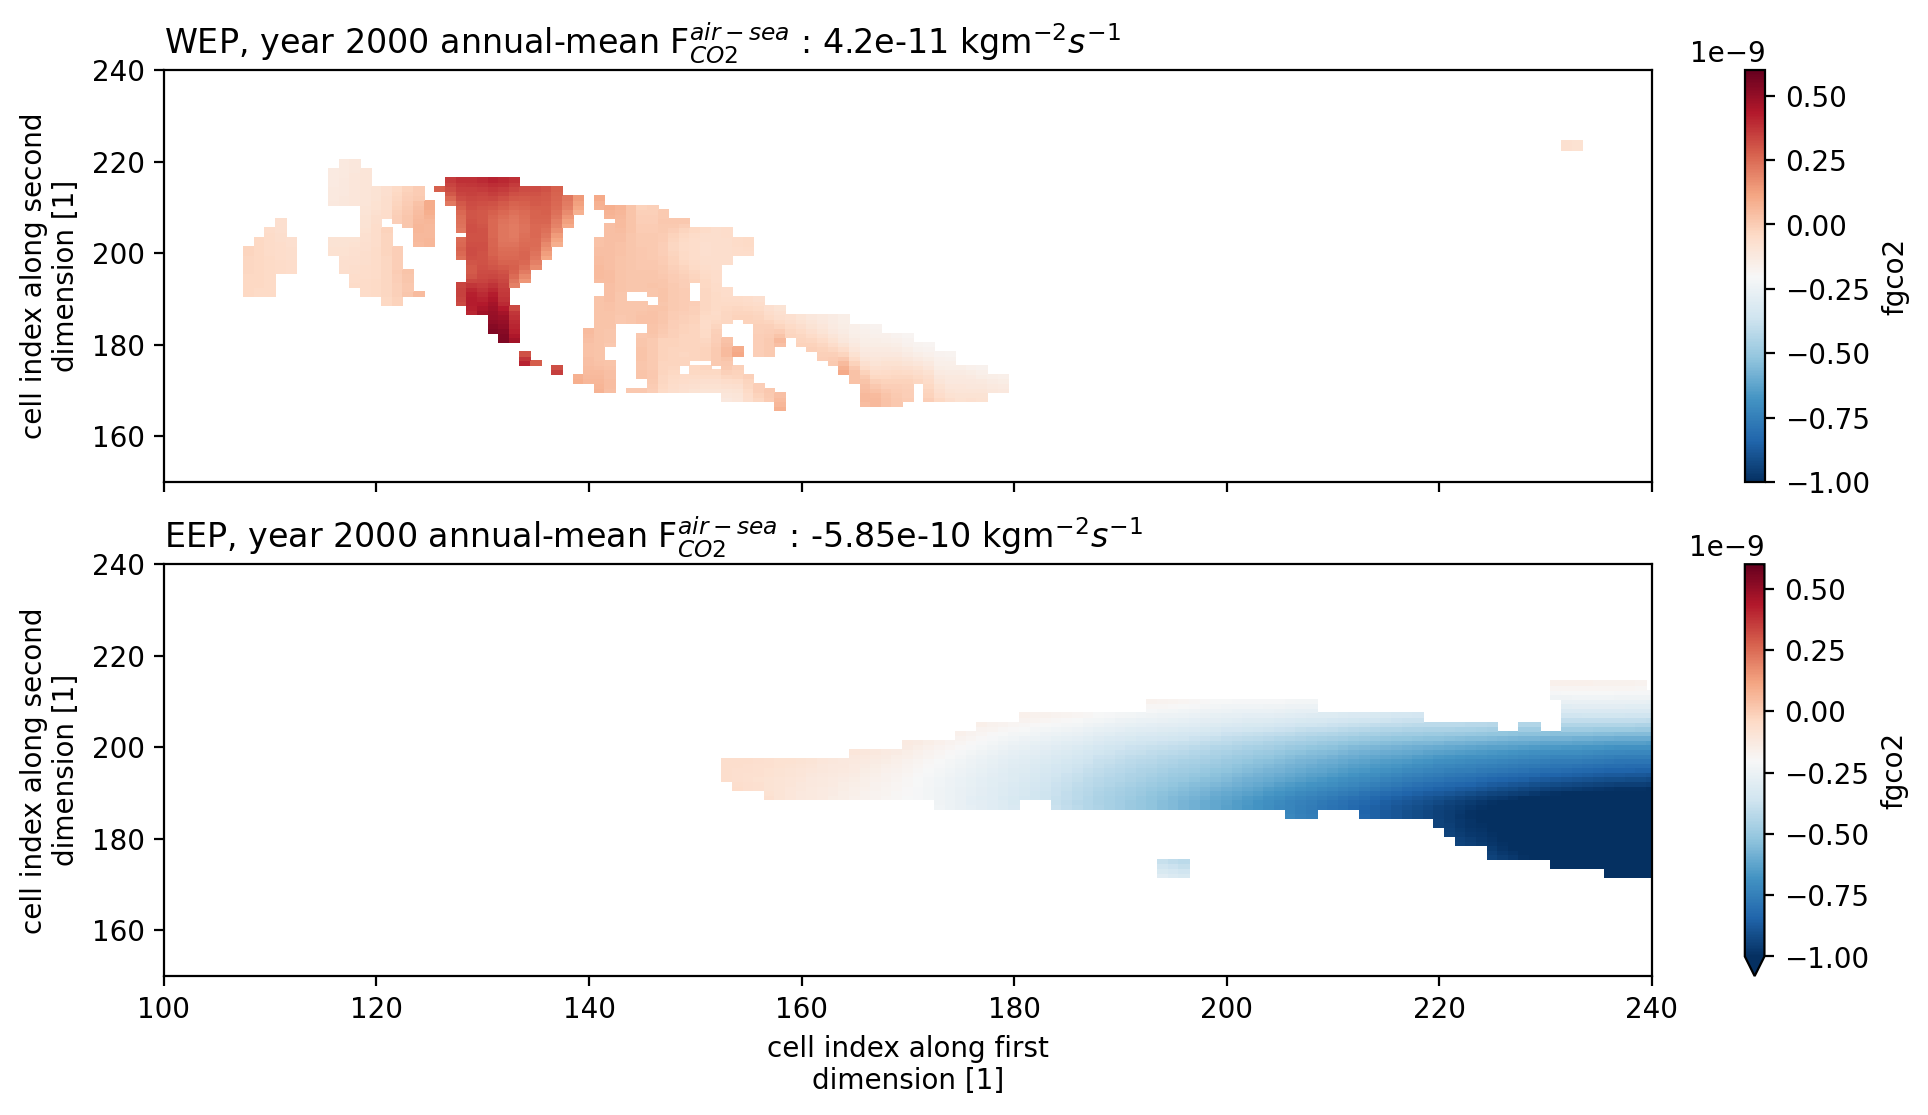

In [20]:
fig, axes = plt.subplots(nrows=2,ncols=1, dpi=100, sharex=True)

g = fgco2.where(fgco2.biome5_mask == 1.).plot(ax=axes[0],cmap='RdBu_r',
                                             vmin=-1e-9,vmax=6e-10)
h = fgco2.where(fgco2.biome6_mask == 1.).plot(ax=axes[1],cmap='RdBu_r',
                                             vmin=-1e-9,vmax=6e-10)

axes[0].set_title('WEP, year 2000 annual-mean F$_{CO2}^{air-sea}$ : ' + 
                  str("{:.3}".format(wep_mean)) + ' kgm$^{-2}s^{−1}$', loc='left')
axes[1].set_title('EEP, year 2000 annual-mean F$_{CO2}^{air-sea}$ : ' + 
                  str("{:.3}".format(eep_mean)) + ' kgm$^{-2}s^{−1}$', loc='left')

axes[0].set_xlim([100,240])
axes[0].set_ylim([150,240])
axes[1].set_xlim([100,240])
axes[1].set_ylim([150,240])
axes[0].set_xlabel('')

In [21]:
eqpac = new_biome5 + new_biome6
fgco2['eqpac_mask'] = (('nlat','nlon'), eqpac)

(150.0, 240.0)

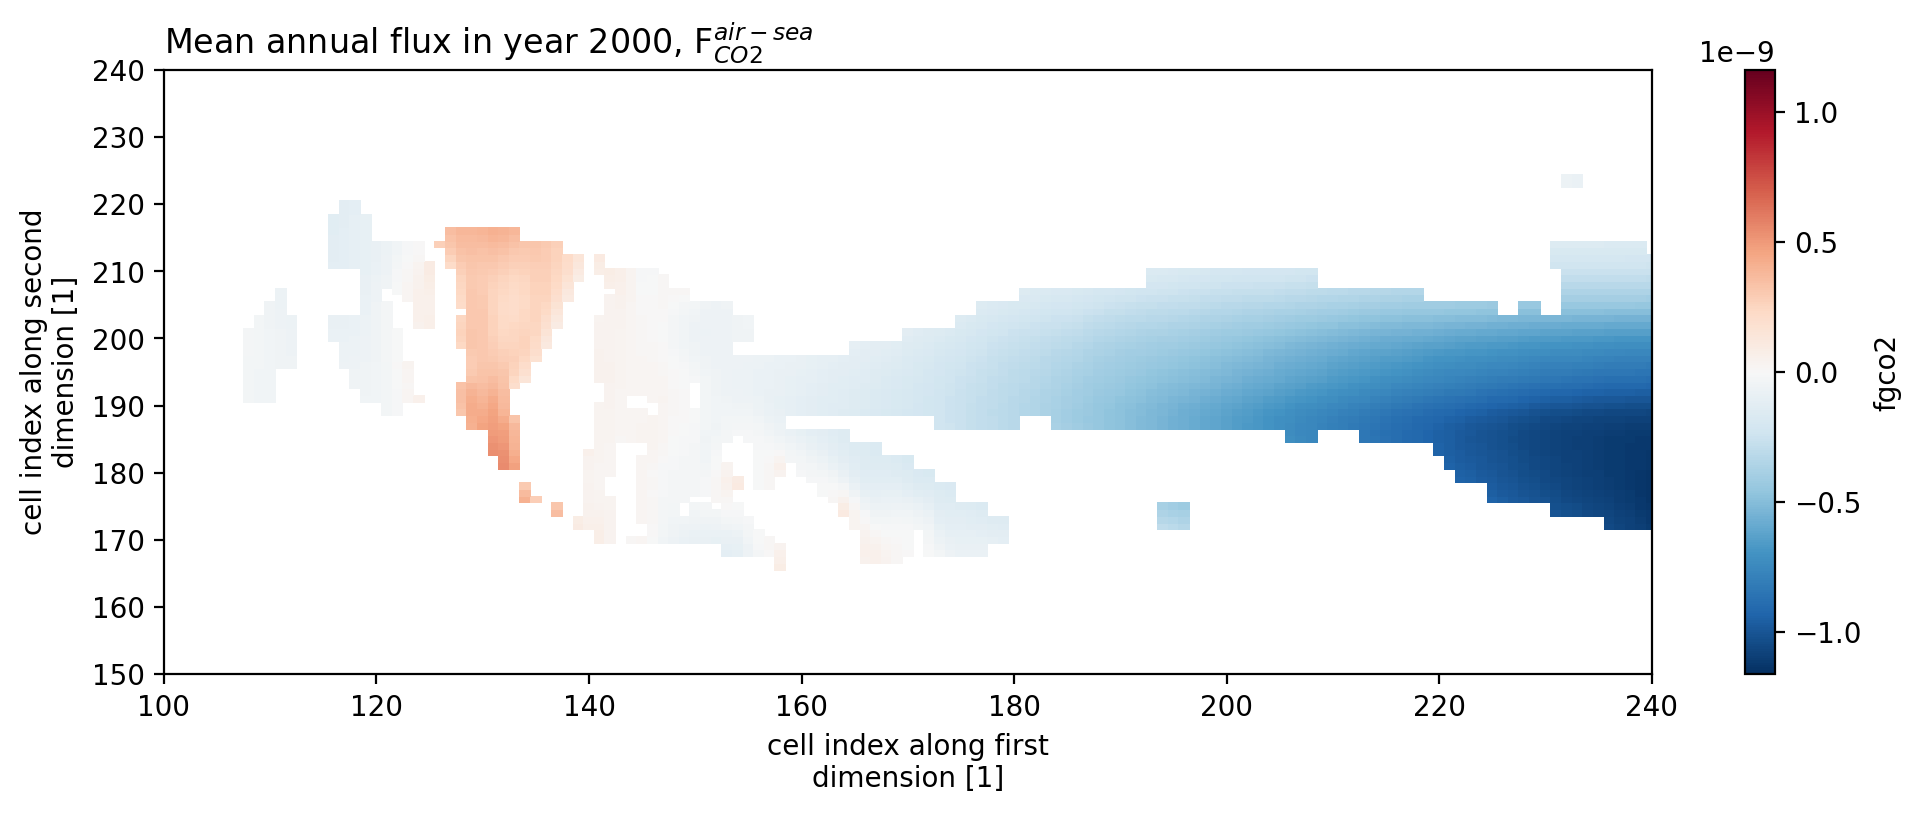

In [22]:
fig, axes = plt.subplots(nrows=1,ncols=1, dpi=100, figsize=(12,4))

fgco2.where(fgco2.eqpac_mask == 1.).plot()

axes.set_title('Mean annual flux in year 2000, F$_{CO2}^{air-sea}$',loc='left')

axes.set_xlim([100,240])
axes.set_ylim([150,240])

> This was just the ensemble mean annual flux in year 2000, for one model **CESM2**

Recall:
```
# look at one model
ds = dset_dict['CESM2']

# calculate ensemble mean annual flux in year 2000
fgco2 = ds.fgco2.sel(time='2000', method='nearest').mean(dim=['time', 'member']).load()
fgco2.plot()
```

# Make this for any model

In [69]:
models = [names[0] for names in dset_dict.items()]
models

['ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'GISS-E2-1-G',
 'GISS-E2-1-G-CC',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorCPM1',
 'NorESM2-LM',
 'NorESM2-MM']

In [70]:
def model(name):
    ds = dset_dict[name]
    display(ds)
    # calculate ensemble mean annual flux in year 2000
    fgco2 = ds.fgco2.sel(time='2000', method='nearest').mean(dim=['time', 'member']).load()
    
    img = biome5
    nearest_5 = cv2.resize(img, dsize=(320, 384), interpolation=cv2.INTER_NEAREST)

    img2 = biome6
    nearest_6 = cv2.resize(img2, dsize=(320, 384), interpolation=cv2.INTER_NEAREST)

,Array,Chunk
Bytes,10.71 GB,58.98 MB
Shape,"(11, 1980, 384, 320)","(1, 120, 384, 320)"
Count,1044 Tasks,297 Chunks
Type,float32,numpy.ndarray


C:\Users\sukic\Anaconda3\envs\geosci\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


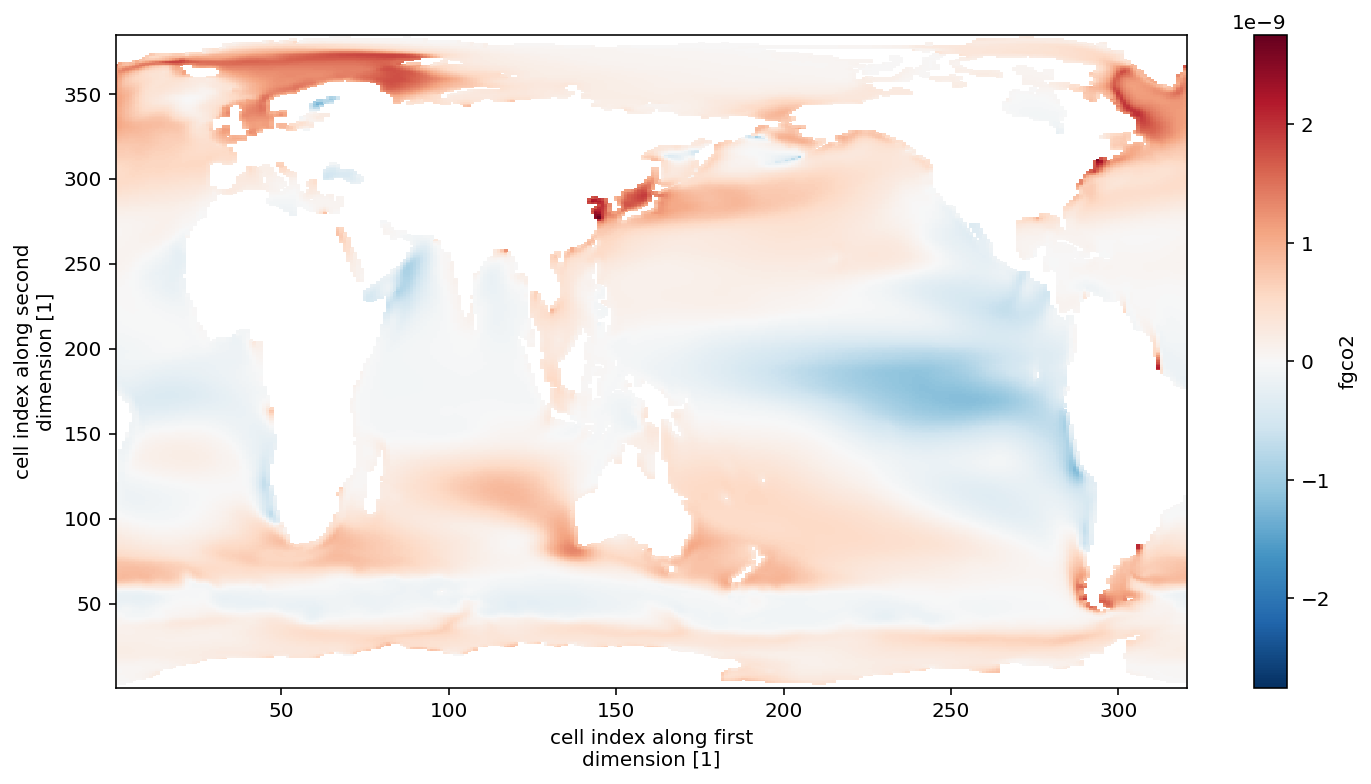

In [57]:
model('CESM2')